In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

In [98]:
land_df = pd.read_csv("daily_corona_data/aggregate_bundesland.csv", index_col=0)
land_df.Meldedatum = land_df.Meldedatum.transform(lambda x: datetime.datetime.strptime(re.sub("T.*", "", x), "%Y-%m-%d"))
land_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 278
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Meldedatum             293 non-null    datetime64[ns]
 1   Bundesland             293 non-null    object        
 2   AnzahlFall             293 non-null    int64         
 3   AnzahlTodesfall        293 non-null    int64         
 4   TotalAnzahlBundesland  293 non-null    int64         
 5   TotalDeathBundesland   293 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 16.0+ KB


In [109]:
datetime.datetime.strptime("2020-01-03", "%Y-%m-%d")

datetime.datetime(2020, 1, 3, 0, 0)

In [99]:
type(land_df.iloc[0, 0])

pandas._libs.tslibs.timestamps.Timestamp

In [100]:
lander = land_df.Bundesland.unique()
lander = [land for land in lander if land != "-nicht erhoben-"]

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


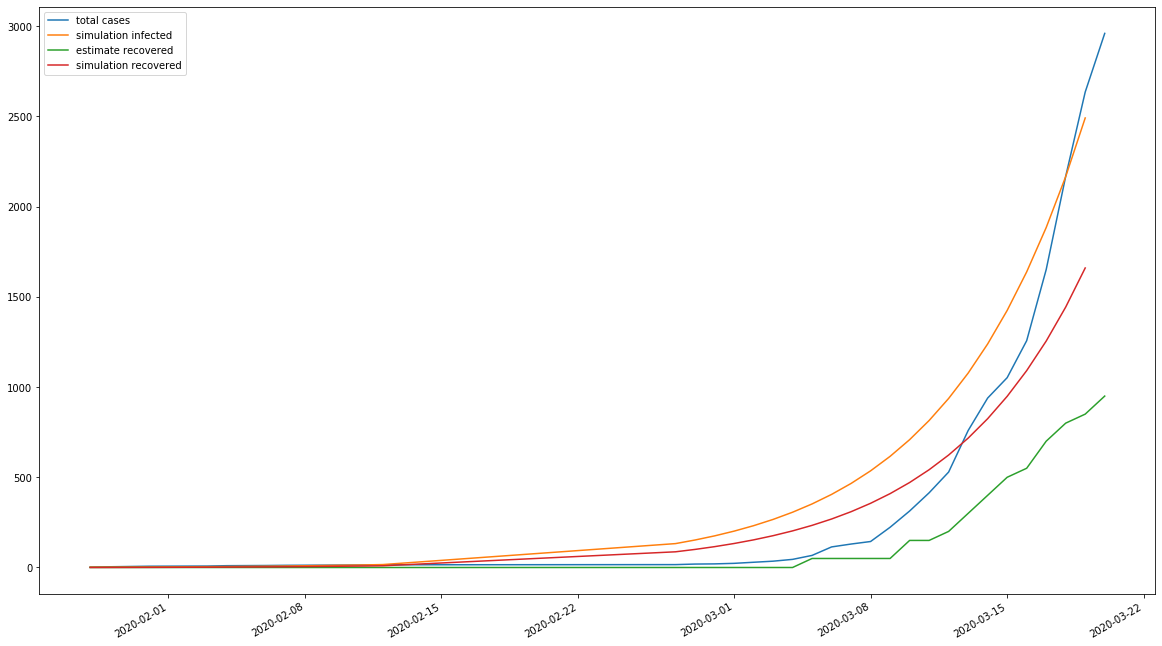

In [132]:
land = lander[0]
temp_df = land_df[land_df.Bundesland == land]
n_days =(temp_df.iloc[-1].Meldedatum - temp_df.iloc[0].Meldedatum).days
temp_df = temp_df.set_index("Meldedatum")
tot_pop = 13000000.0

i_0 = 2 / tot_pop
s_0 = 1 - i_0
r_0 = 0

evol = [{"i": i_0, "r": r_0, "s": s_0}]

R0 = 2.5
g = 1 / 10
b = R0 * g

for day in range(1, n_days):
    s = evol[-1]["s"]
    r = evol[-1]["r"]
    i = evol[-1]["i"]
    new_s = s - b * i * s
    new_r = r + g * i
    new_i = i + b * i * s - g * i
    evol.append({"s": new_s, "r": new_r, "i": new_i})
    
temp_df[["i", "r", "s"]] = pd.DataFrame(evol, index=[datetime.datetime(2020, 1, 28, 0, 0) + datetime.timedelta(days=j) for j in range(n_days)]) * tot_pop
# Assume that 10% of the hospitalized die, and 20% of the sick are hospitalized
temp_df["Recovered"] = temp_df.TotalDeathBundesland * 10 * 5

fig = plt.figure(figsize=(20, 12))
plt.plot(temp_df.index, 'TotalAnzahlBundesland', data=temp_df, label="total cases")
plt.plot(temp_df.index, 'i', data=temp_df, label="simulation infected")
plt.plot(temp_df.index, 'Recovered', data=temp_df, label="estimate recovered")
plt.plot(temp_df.index, 'r', data=temp_df, label="simulation recovered")
plt.legend()
fig.autofmt_xdate()
plt.show()